In [4]:
# All Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import requests
from PIL import Image

In [5]:
# All functions required
def load_image(name, no_alpha=True):
    url = f'https://cloud.dfki.de/owncloud/index.php/s/THLirfoB6SYTetn/download?path=&files={name}'
    image = np.asarray(Image.open(requests.get(url, stream=True).raw))
    if no_alpha and len(image) > 2 and image.shape[2] == 4:
        image = image[:,:,:3]
    return image[:,:,::-1].copy()

def resize(image, scale):
    return cv2.resize(image, (int(image.shape[1]*scale), int(image.shape[0]*scale)))

def show(*images, titles=None, figsize=None, **kwargs):
    ROWS, COLS = 1, len(images)
    if figsize is not None:
        plt.figure(figsize=(18,6))
    for i, img in enumerate(images):
        plt.subplot(ROWS, COLS, i+1)
        if titles is not None:
            plt.title(titles[i])
        if len(img.shape) == 3:
            plt.imshow(img[:,:,::-1], **kwargs)
        else:
            plt.imshow(img, **kwargs)
    plt.show()

def extract_corners(I: np.array) -> np.array:
    if (I.shape == 3) and (I.shape[2] == 3):
        raise ValueError("Image should be converted to grayscale!")
    max_corners = 100
    quality_level = 0.01
    min_distance = 10
    corners = cv2.goodFeaturesToTrack(I, max_corners, quality_level, min_distance)
    corners = corners[:, 0, [1, 0]]
    return corners
    
def gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def visualize_keypoints_and_orientations(img, keypoints):
    fig, ax = plt.subplots(1)
    ax.imshow(img, cmap='gray')
    for point in keypoints:
        u, v, _, orient = point
        circle = patches.Circle((v, u), radius=10, edgecolor='r', facecolor='none')
        ax.add_patch(circle)
        dx = 10 * np.cos(np.deg2rad(orient * 45))
        dy = 10 * np.sin(np.deg2rad(orient * 45))
        ax.arrow(v, u, dx, dy, color='r', head_width=2, head_length=2)
    plt.show()

def visualize_corners(img, corners):
    plt.imshow(img, cmap='gray')
    plt.scatter(corners[:, 1], corners[:, 0], color='red', s=10)
    plt.show()

def visualize_optical_flow(img, corners, points):
    plt.imshow(img, cmap='gray')
    for corner, point in zip(corners, points):
        y, x = corner
        ydy, xdx = point
        plt.arrow(x, y, xdx - x, ydy - y, color='green', head_width=0.5, head_length=0.5)
    plt.show()

<p style="page-break-after:always;"></p>

# Task: Optical Flow
---

The Lucas-Kanade method is a differential method for optical flow estimation. It assumes that the flow is essentially constant in a small neighborhood of the pixel under consideration, and solves the basic optical flow equations for all the pixels in that neighborhood by the least squares criterion.


Goal of this task is to implement the Lucas-Kanade optical flow method (https://en.wikipedia.org/wiki/Lucas%E2%80%93Kanade_method).

**Given Step:**
* Load new images, extract corners and visualize corners.

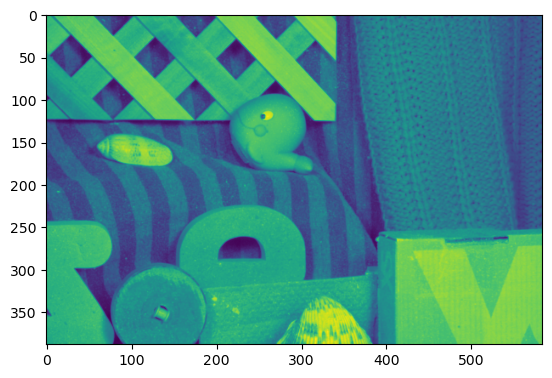

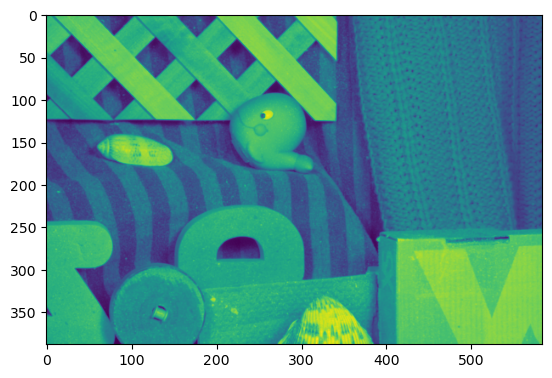

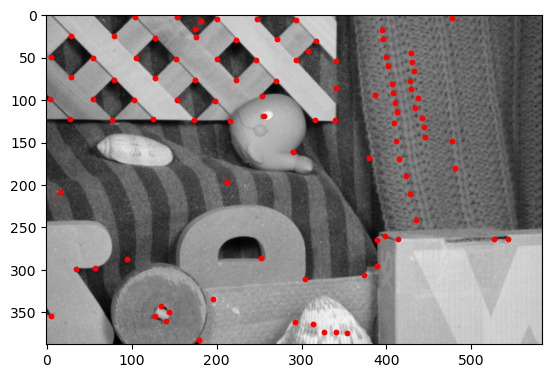

In [6]:
# Images loading
im1 = gray(load_image('frame07.png'))
im2 = gray(load_image('frame08.png'))
show(im1)
show(im2)
# Extract corners from the first image using goodFeaturesToTrack
corners = extract_corners(im1)
visualize_corners(im1, corners)

im1f = im1.astype(float)
im2f = im2.astype(float)

Helper equations for the next section

![image-4.png](image-4.png)

![image-5.png](image-5.png)

Implementing the pipeline of Lucas-Kanade algorithm.
1. Estimate spatial gradients for the first image using central differences
2. Estimate temporal intensity differences (difference between second and first image)
3. For every corner:
   * Take the window of spatial gradients with the specified window size around this corner and flatten it 
   * Join the values into the matrix $A$ (using `vstack` to join two columns)
   * Take the negative values of temporal intensity differences within the window and form a vector $b$
   * Solve the equation $Ax=b$ using least squares. $x$ forms the velocity of the particular point

In [7]:
def find_optical_flow(im1f, im2f, corners):
    # TODO Select appropriate window size (empirically)
    window_size = 5                                                     

    Ix = np.zeros_like(im1f)                                            # Initialising Ix array
    Iy = np.zeros_like(im1f)                                            # Initialising Iy array

    # TODO Find gradient in first image (using central differences)
    Ix[1:-1, :] = (im1f[2:, :] - im1f[:-2, :])/2                        # Central difference on x
    Iy[:, 1:-1] = (im1f[:, 2:] - im1f[:,:-2])/2                         # central difference on y

    # TODO Find temporal difference
    It = im2f-im1f

    points = []

    for idx, corner in enumerate(corners):
        y, x = np.round(corner).astype(int)

        # TODO define windows Ix_win, Iy_win, It_win of Ix, Iy and It based on the window_size variable
        Ix_win = Ix[y-window_size//2:y+window_size//2+1,x-window_size//2:x+window_size//2+1]
        Iy_win = Iy[y-window_size//2:y+window_size//2+1,x-window_size//2:x+window_size//2+1]
        It_win = It[y-window_size//2:y+window_size//2+1,x-window_size//2:x+window_size//2+1]

        Ix_win = Ix_win.flatten()
        Iy_win = Iy_win.flatten()
        It_win = It_win.flatten()

        # TODO form matrix A based on Ix_win and Iy_win, and vector b on It_win
        A = np.vstack((Ix_win,Iy_win)).T                                            # Since matrix A comprises of a column of Ix and a column of Iy
        b = -It_win

        # TODO solve Ax=b using least squares, x = [u, v]
        # Use only the first output of the corresponding function
        # Using the function np.linalg.lstsq gives us the output uv, with rank of the matrix and residuals
        uv = np.linalg.lstsq(A,b,rcond=None)[0]                                                
        
        # Forming the point as original corner coordinate plus the estimated velocity
        points.append([y+uv[0], x+uv[1]])
    return np.array(points)

In [8]:
points = find_optical_flow(im1f, im2f, corners)

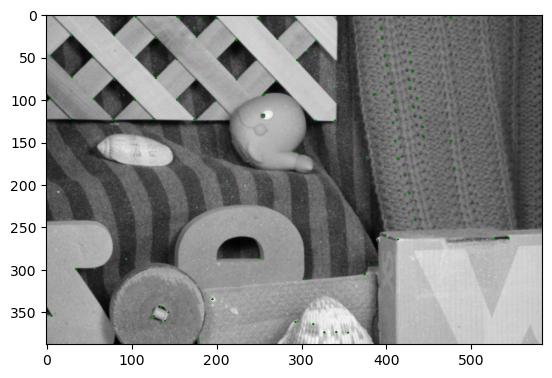

In [9]:
visualize_optical_flow(im2, corners, points)